In [1116]:
# Import packages
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os
import dill, sys
import copy
import numpy as np
import matplotlib.pyplot as plt
import scarlet

import kuaizi as kz
from kuaizi.display import display_single, SEG_CMAP, display_scarlet_results_tigress
from kuaizi.detection import Data

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, Row, vstack, hstack
from astropy.coordinates import SkyCoord

from PIL import Image

sys.path.append('/home/jiaxuanl/Research/Packages/kuaizi/diezi/scarlet_modeling/script/')

In [165]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/scratch/gpfs/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)
kz.set_matplotlib(style='JL', usetex=True, dpi=100, fontsize=16)

### We have already made cuts in `NSA-structure-vanilla-cuts-all.ipynb`. Now we select UDGs, make visual inspection, and plot some useful figures

In [656]:
input_cuts_cat = Table.read('./Catalog/nsa_z001_004/lsbg_after_cuts_spergel.fits')
from sample_cuts import post_process_cat_new
cuts_cat = post_process_cat_new(input_cuts_cat)

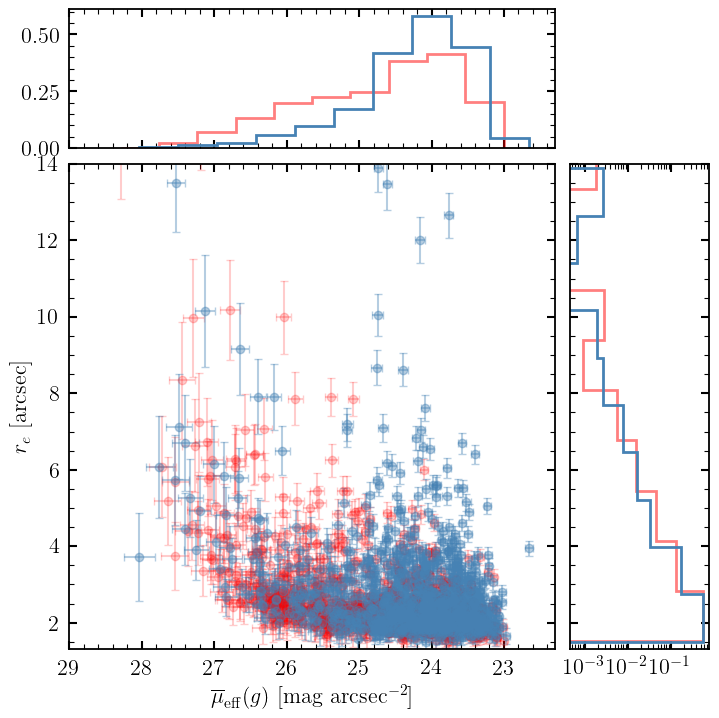

In [657]:
# Distribution of the full sample after junk cuts
fig = plt.figure(figsize=(8, 8))

gs = fig.add_gridspec(2, 2,  width_ratios=(7, 2), height_ratios=(2, 7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)


red = (cuts_cat['g-i'].data > 0.8)

ax.errorbar(cuts_cat[red]['SB_eff_avg'][:, 0], 
            cuts_cat[red]['rhalf_spergel'], 
            xerr=cuts_cat[red]['SB_eff_avg_err'][:, 0],
            yerr=cuts_cat[red]['rhalf_spergel_err'],
            color='r', fmt='o', alpha=0.2)

ax.errorbar(cuts_cat[~red]['SB_eff_avg'][:, 0], 
            cuts_cat[~red]['rhalf_spergel'], 
            xerr=cuts_cat[~red]['SB_eff_avg_err'][:, 0],
            yerr=cuts_cat[~red]['rhalf_spergel_err'],
            color='steelblue', fmt='o', alpha=0.4)

ax.set_xlim(29, 22.3)
ax.set_ylim(1.3, 14)
ax.set_xlabel(r'$\overline{\mu}_{\rm eff}(g)\ [\rm mag\ arcsec^{-2}]$')
ax.set_ylabel(r'$r_e\ [\rm arcsec]$')

ax_histx.hist(cuts_cat[red]['SB_eff_avg'][:, 0], lw=2,
              histtype='step', density=True, color='r', alpha=0.5)
ax_histx.hist(cuts_cat[~red]['SB_eff_avg'][:, 0], lw=2,
              histtype='step', density=True, color='steelblue')
ax_histy.hist(cuts_cat[red]['rhalf_spergel'], lw=2,
              histtype='step', density=True, orientation='horizontal', color='r', alpha=0.5)
ax_histy.hist(cuts_cat[~red]['rhalf_spergel'], lw=2,
              histtype='step', density=True, orientation='horizontal', color='steelblue')
ax_histy.set_xscale('log')

In [658]:
### Very conservative choise of UDG, including the measurement error
flag = (cuts_cat['rhalf_phys'] + cuts_cat['rhalf_phys_err'] >= 1.5
       ) & (cuts_cat['SB_eff_avg'][:, 0] + cuts_cat['SB_eff_avg_err'][:, 0] >= 24.5)

print('# of UDGs:', np.sum(flag))

# of UDGs: 438


In [659]:
udg_cat = cuts_cat[flag]

In [660]:
junk = (udg_cat['bad_votes'] > udg_cat['good_votes'])
candy = (udg_cat['good_votes'] > udg_cat['bad_votes']) & (
    udg_cat['is_candy'] > udg_cat['is_galaxy'])
gal = (~junk) & (~candy)
print('# of Candy:', np.sum(candy))
print('# of Gal:', np.sum(gal))
print('# of Junk:', np.sum(junk))

# of Candy: 354
# of Gal: 71
# of Junk: 13


In [661]:
udg_cat[['viz-id', 'ra', 'dec']].write(
    '/tigress/jiaxuanl/public_html/galary/catalogs/nsa_z001_004/udg_z001_004_spergel.txt', 
    format='ascii')

---
### Visual inspection: mark junks

In [662]:
cuts_cat[cuts_cat['viz-id'] == 79056]

viz-id,ra,dec,image_flag [5],psf_flag [5],radius,flux [4],mag [3],mag_err [3],g-i,g-i_err,g-r,g-r_err,SB_eff_avg [3],SB_eff_avg_err [3],rhalf_spergel,rhalf_spergel_err,rhalf_phys,rhalf_phys_err,abs_mag [3],abs_mag_err [3],log_ML_g,log_ML_g_err,log_m_star,log_m_star_err,completeness,tract,patch,synth_id,mag_auto_g,mag_auto_r,mag_auto_i,flux_radius_ave_g,flux_radius_ave_i,A_g,A_r,A_i,is_candy,is_galaxy,is_tidal,is_outskirts,is_cirrus,is_junk,num_votes,good_votes,bad_votes,host_name,host_z,host_ang_diam_dist,host_stellar_mass,host_halo_mass,host_r_vir,host_r_vir_ang,host_300kpc_ang,host_nvotes,host_spiral,host_elliptical,host_uncertain,host_RA,host_DEC,SB_eff_circ [4],SB_0 [4],ell_cen,ell_sym,PA_cen,PA_sym,rhalf_circularized,spergel_nu,r20,r50,r80,Gini,M20,"F(G,M20)","S(G,M20)",C,A,S,A_outer,A_shape,sersic_n,sersic_rhalf,sersic_ell,sersic_PA,flag_sersic
,deg,deg,,,arcmin,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),arcsec,arcsec,kpc,kpc,mag(AB),mag(AB),,,,,,,,,,,,,,,,,,,,,,,,,,,,Mpc,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int64,float64,float64,bool,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,bytes3,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,bytes19,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
79056,350.2807349,1.4006702,True .. True,True .. True,0.7,375.47442697678514 .. 980.816781226347,20.628571470996683 .. 19.784457082272887,0.11369977258166739 .. 0.10729449390693674,0.8508298035212429,0.07144736301538218,0.2613418400747923,0.06121092131486978,26.44051173695606 .. 25.59639734823227,0.11369977258166739 .. 0.10729449390693674,6.400797565801927,0.7842773929207597,4.0262323710485015,0.4933264948308789,-15.06704140997502 .. -15.911155798698816,0.11369977258166739 .. 0.10729449390693674,-0.035426660270133276,0.09266722983095069,8.003389903719876,0.10322614789946344,0.6652054947363608,9705,"1,7",-1,21.7703,20.6046,20.2358,3.642828,6.3060480000000005,0.12317700248030716,0.08728688916869276,0.06229334953767467,0,0,0,2,0,0,2,0,2,J232119.40+012410.9,0.03042442724108696,129.74489686275106,11.04596075368844,13.100223541259766,602.7204718289128,0.2661633849232924,0.13248100771273208,nan,nan,nan,nan,350.3307495893224,1.4031426948407324,27.210615174193563 .. 26.16809636269701,25.748860637971664 .. 24.70634182647511,0.5449012879038678,0.544901306722338,-1.5518726929787832,-1.5518727097555995,5.788563848890138,1.452804543305469,18.452671439236987,36.24818271567082,63.081672400244756,0.47012062396457505,-1.6840770447444993,-0.46583751936741535,-0.09566729149455613,2.6692197486925737,0.0003302894642516881,0.012284582270289163,0.000677343262163398,0.1670427144539211,0.7493247535854362,52.10264668149974,0.5687636321098563,1.5893153854698399,0.0


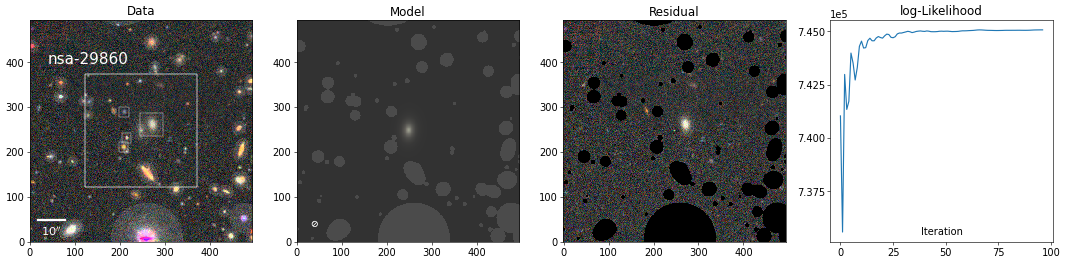

In [663]:
method = 'spergel'
Image.open(f'./Figure/nsa_z002_004/{method}/nsa-29860-zoomin-{method}.png')

In [664]:
votes = Table.read('/tigress/jiaxuanl/public_html/galary/catalogs/nsa_z001_004/udg_z001_004_votes.txt',
                   format='ascii')
flag = ~(votes['marked'] == 'true')

In [665]:
udg_cat = udg_cat[flag]

In [666]:
print('Hosts for LSBGs after cuts:', len(np.unique(cuts_cat['host_name'])))
print('')
print('LSBGs after cuts:', len(cuts_cat))
print('UDGs:', len(udg_cat))
print('UDG hosts:', len(np.unique(udg_cat['host_name'])))

print('UDG fraction:', len(udg_cat) / len(np.unique(cuts_cat['host_name'])))
## SAGA UDG fraction: 1/6 = 0.167
junk = (udg_cat['bad_votes'] > udg_cat['good_votes'])
candy = (udg_cat['good_votes'] > udg_cat['bad_votes']) & (
    udg_cat['is_candy'] > udg_cat['is_galaxy'])
gal = (~junk) & (~candy)
print('')
print('# of Candy:', np.sum(candy))
print('# of Gal:', np.sum(gal))
print('# of Junk:', np.sum(junk))

Hosts for LSBGs after cuts: 640

LSBGs after cuts: 2056
UDGs: 424
UDG hosts: 278
UDG fraction: 0.6625

# of Candy: 349
# of Gal: 69
# of Junk: 6


In [667]:
udg_cat.write(f'/tigress/jiaxuanl/public_html/galary/catalogs/nsa_z001_004/udg_z001_004_spergel_after_viz.fits', 
              overwrite=True)
udg_cat[['viz-id', 'ra', 'dec']].write(
    '/tigress/jiaxuanl/public_html/galary/catalogs/nsa_z001_004/udg_z001_004_spergel_after_viz.txt', format='ascii')

---

In [668]:
udg_cat = Table.read('/tigress/jiaxuanl/public_html/galary/catalogs/nsa_z001_004/udg_z001_004_spergel_after_viz.fits')

[Text(0.0, 0, ''), Text(0.5, 0, ''), Text(1.0, 0, '')]

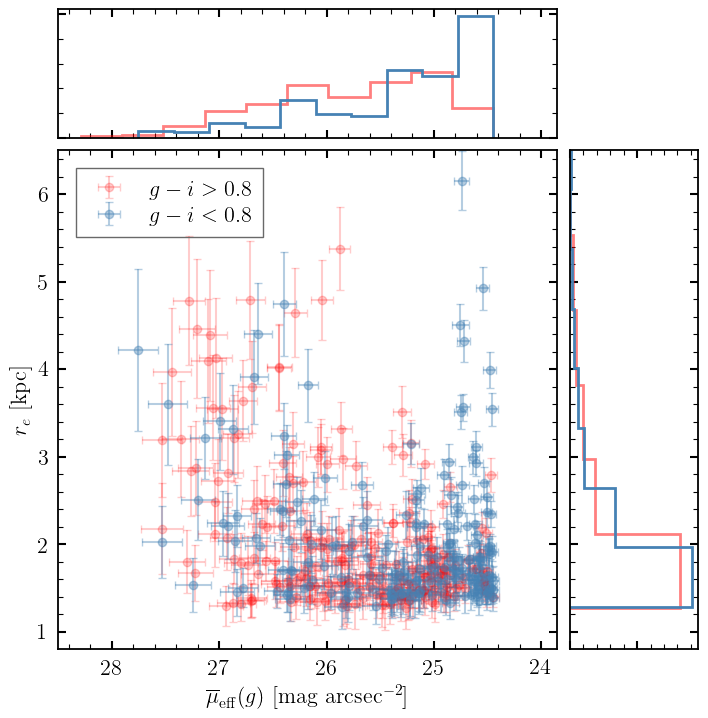

In [669]:
# Distribution of the full sample after junk cuts
fig = plt.figure(figsize=(8, 8))

gs = fig.add_gridspec(2, 2,  width_ratios=(7, 1.8), height_ratios=(1.8, 7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.04, hspace=0.04)

ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)


red = (udg_cat['g-i'].data > 0.8)

ax.errorbar(udg_cat[red]['SB_eff_avg'][:, 0], 
            udg_cat[red]['rhalf_phys'], 
            xerr=udg_cat[red]['SB_eff_avg_err'][:, 0],
            yerr=udg_cat[red]['rhalf_phys_err'],
            color='r', fmt='o', alpha=0.2, label='$g-i > 0.8$')

ax.errorbar(udg_cat[~red]['SB_eff_avg'][:, 0], 
            udg_cat[~red]['rhalf_phys'], 
            xerr=udg_cat[~red]['SB_eff_avg_err'][:, 0],
            yerr=udg_cat[~red]['rhalf_phys_err'],
            color='steelblue', fmt='o', alpha=0.4, label='$g-i < 0.8$')

leg = ax.legend(loc='upper left', frameon=True)
leg.get_frame().set_facecolor('none')
leg.get_frame().set_edgecolor('dimgray')
leg.get_frame().set_boxstyle('Square', pad=0.)

ax.set_xlim(28.5, 23.85)
ax.set_ylim(0.8, 6.5)
ax.set_xlabel(r'$\overline{\mu}_{\rm eff}(g)\ [\rm mag\ arcsec^{-2}]$')
ax.set_ylabel(r'$r_e\ [\rm kpc]$')

ax_histx.hist(udg_cat[red]['SB_eff_avg'][:, 0], lw=2,
              histtype='step', density=True, color='r', alpha=0.5)
ax_histx.hist(udg_cat[~red]['SB_eff_avg'][:, 0], lw=2,
              histtype='step', density=True, color='steelblue')
ax_histy.hist(udg_cat[red]['rhalf_phys'], lw=2,
              histtype='step', density=True, orientation='horizontal', color='r', alpha=0.5)
ax_histy.hist(udg_cat[~red]['rhalf_phys'], lw=2,
              histtype='step', density=True, orientation='horizontal', color='steelblue')
ax_histx.set_yticklabels([])
ax_histy.set_xticklabels([])
# ax_histy.set_xscale('log')

In [670]:
kz.set_matplotlib(style='default', usetex=False, dpi=60, fontsize=13)

Text(0.5, 0, '$d_{\\rm ang} / R_{\\rm vir, ang}$')

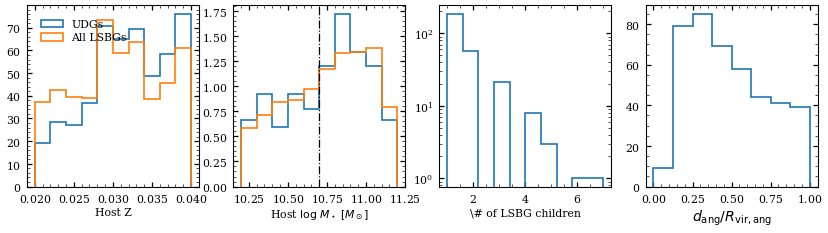

In [671]:
fig, axes = plt.subplots(1, 4, figsize=(17, 4))

plt.sca(axes[0])
plt.hist(udg_cat['host_z'], range=[0.02, 0.04], 
         bins=10, histtype='step', lw=2, density=True, label='UDGs');
plt.hist(cuts_cat['host_z'], range=[0.02, 0.04], 
         bins=10, histtype='step', lw=2, density=True, label='All LSBGs');
plt.xlabel('Host Z')
plt.legend(loc='upper left')

plt.sca(axes[1])
plt.hist(udg_cat['host_stellar_mass'], range=[10.2, 11.2], 
         bins=10, histtype='step', lw=2, density=True, label='UDGs');
plt.hist(cuts_cat['host_stellar_mass'], range=[10.2, 11.2], 
         bins=10, histtype='step', lw=2, density=True, label='All LSBGs');
plt.xlabel(r'Host $\log\, M_\star\ [M_\odot]$')
plt.axvline(10.7, c='k', ls='-.')
plt.subplots_adjust(wspace=0.2)

plt.sca(axes[2])
uniques, counts = np.unique(udg_cat['host_name'], return_counts=True)
plt.hist(counts, histtype='step', lw=2)
plt.yscale('log')
plt.xlabel('\# of LSBG children')

plt.sca(axes[3])
lsbg_coord = SkyCoord(udg_cat['ra'], udg_cat['dec'], unit='deg')
host_coord = SkyCoord(udg_cat['host_RA'], udg_cat['host_DEC'], unit='deg')
dist = lsbg_coord.separation(host_coord)
plt.hist(dist.to(u.deg).value / udg_cat['host_r_vir_ang'].data, 
         range=[0, 1.], bins=8, histtype='step', lw=2);
plt.xlabel(r'$d_{\rm ang} / R_{\rm vir, ang}$', fontsize=17)

(array([  3.,   8.,  15.,  40.,  50.,  67., 111., 107.,  18.,   5.]),
 array([0.15702272, 0.26007967, 0.36313661, 0.46619356, 0.5692505 ,
        0.67230745, 0.7753644 , 0.87842134, 0.98147829, 1.08453523,
        1.18759218]),
 <BarContainer object of 10 artists>)

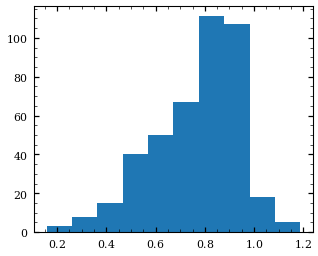

In [672]:
plt.hist(udg_cat['g-i'])

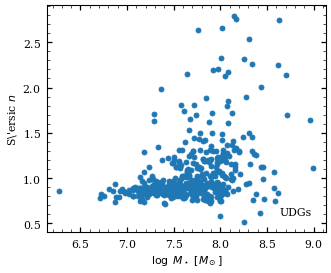

In [673]:
sct = plt.scatter(udg_cat['log_m_star'], 
            udg_cat['sersic_n'], 
            label='UDGs')

plt.xlabel(r'$\log\ M_\star\ [M_\odot]$')
plt.ylabel(r'S\'ersic $n$')
plt.legend(loc='lower right')

(array([ 14.,  49., 117.,  39.,  31.,  23.,  39.,  30.,  40.,  42.]),
 array([0.        , 0.08224507, 0.16449014, 0.24673521, 0.32898028,
        0.41122535, 0.49347042, 0.5757155 , 0.65796057, 0.74020564,
        0.82245071]),
 <BarContainer object of 10 artists>)

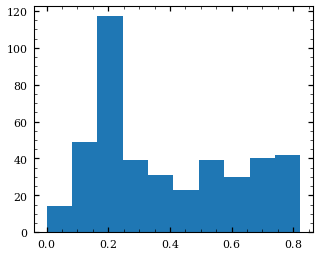

In [674]:
plt.hist(udg_cat['completeness'])

In [675]:
from scipy.stats import binned_statistic
quench_frac, bin_edges, _ = binned_statistic(np.nan_to_num(udg_cat['log_m_star'].data), (udg_cat['g-i'].data > 0.7), 
                                             statistic='mean', range=(7, 9), bins=8)
num, bin_edges, _ = binned_statistic(np.nan_to_num(udg_cat['log_m_star'].data), (udg_cat['g-i'] > 0.7), 
                                             statistic='count', range=(7, 9), bins=8)

Text(0, 0.5, 'Quenched Fraction ($g - i > 0.8$)')

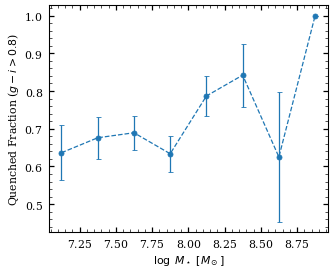

In [344]:
plt.errorbar((bin_edges[:-1] + bin_edges[1:]) / 2, 
             quench_frac, yerr=np.sqrt(quench_frac * (1 - quench_frac) / num), fmt='o--')
plt.xlabel(r'$\log\ M_\star\ [M_\odot]$')
plt.ylabel(r'Quenched Fraction ($g - i > 0.8$)')

## Size distribution 
1. Subtract background contribution
2. Correct for completeness

In [676]:
kz.set_matplotlib(style='JL', usetex=True, dpi=100, fontsize=16)

In [677]:
_, ind = np.unique(udg_cat['host_name'].data, return_index=True)
total_area = (np.pi * udg_cat['host_r_vir_ang'].data[ind]**2).sum() # deg^2
print('Total angular area [deg2]:', total_area)

Total angular area [deg2]: 33.767023651338576


In [678]:
from sample_cuts import moving_binned_statistic

In [685]:
n_bins = 10
n_slide = 20
range_0 = np.array([np.log10(1.5), np.log10(6.1)])

In [686]:
# R_e distribution of the real udg sample
output, cen = moving_binned_statistic(np.log10(udg_cat['rhalf_phys']), 
                                      np.log10(udg_cat['rhalf_phys']), 
                                      x_err=udg_cat['rhalf_phys_err'],
                                      bins=n_bins, range_=range_0, 
                                      statistic='count', n_slide=n_slide)

n_cen = np.nanmean(output, axis=0) / (1) / total_area / np.diff(cen)[0]
n_std = np.nanstd(output, axis=0) / (1) / total_area / np.diff(cen)[0]

In [687]:
# R_e distribution of the fake udg sample: remove background
fake_udg_cat = Table.read('./Catalog/random_field/fake_udg_cat_220519.fits')
output, cen = moving_binned_statistic(np.log10(fake_udg_cat['rhalf_phys']), 
                                      np.log10(fake_udg_cat['rhalf_phys']), 
                                      x_err=fake_udg_cat['rhalf_phys_err'],
                                      bins=n_bins, range_=range_0, 
                                      statistic='count', n_slide=n_slide)
n_cen_bkg = np.nanmean(output, axis=0) / (5 * 20) / 24 / np.diff(cen)[0]
n_std_bkg = np.nanstd(output, axis=0) / (5 * 20) / 24 / np.diff(cen)[0]

In [688]:
# completeness in each size bin
output, cen = moving_binned_statistic(np.log10(udg_cat['rhalf_phys']), 
                                      udg_cat['completeness'], 
                                      x_err=udg_cat['rhalf_phys_err'],
                                      bins=n_bins, range_=range_0, 
                                      statistic=np.nanmean, 
                                      n_slide=n_slide)
comp_avg = np.nanmean(output, axis=0)
comp_std = np.nanstd(output, axis=0)

(0.3, 250)

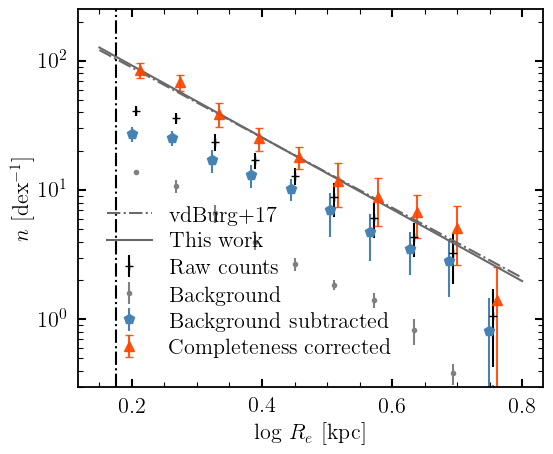

In [846]:
sct1 = plt.errorbar(cen, n_cen, yerr=n_std, 
             capsize=0,
             fmt='+', color='k', label='Raw counts')

sct2 = plt.errorbar(cen, n_cen_bkg, capsize=0,
             yerr=n_std_bkg, fmt='.', color='gray',
             markersize=6, label='Background')

sct3 = plt.errorbar(cen - 0.006, n_cen - n_cen_bkg, capsize=0,
             yerr=n_std, fmt='p', color='steelblue',
             markersize=7, label='Background subtracted')

sct4 = plt.errorbar(cen + 0.006, (n_cen - n_cen_bkg) / comp_avg, 
             yerr=np.sqrt(n_std**2 + n_std_bkg**2) / comp_avg, 
             fmt='^', color='orangered', alpha=0.9,
             markersize=7, label='Completeness corrected')

x0 = np.linspace(0.15, 0.8)
line1 = plt.plot(x0, 10**(-2.71 * x0 + 2.49), ls='-.', color='dimgray', label='vdBurg+17')
line2 = plt.plot(x0, 10**(-2.78 * x0 + 2.52), color='dimgray', label='This work')
plt.axvline(np.log10(1.5), ls='-.', color='k')

plt.xlabel(r'$\log\,R_e\ [\rm kpc]$')
plt.ylabel(r'$n\ [\rm dex^{-1}]$')

plt.legend()
plt.yscale('log')
plt.ylim(0.3, 250)

#### Fit size power law

In [832]:
x = cen[:-1]
y = ((n_cen - n_cen_bkg) / comp_avg)[:-1]
yerr=(np.sqrt(n_std**2 + n_std_bkg**2) / comp_avg)[:-1]

In [833]:
import numpy as np
import jax.numpy as jnp
from jax import random

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

def model(x, y=None, yerr=0.1):
    a = numpyro.sample('a', dist.Uniform(-20, 0))
    b = numpyro.sample('b', dist.Uniform(-10, 10))
    y_ = 10**(b + a * x)
    # notice that we clamp the outcome of this sampling to the observation y 
    numpyro.sample('obs', dist.Normal(y_, yerr), obs=y)
    
# need to split the key for jax's random implementation
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# run HMC with NUTS
kernel = NUTS(model, target_accept_prob=0.9)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=3000)
mcmc.run(rng_key_, x=x, y=y, yerr=yerr)
mcmc.print_summary()

sample: 100%|██████████| 4000/4000 [00:05<00:00, 765.44it/s, 11 steps of size 2.32e-01. acc. prob=0.92] 


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -2.78      0.25     -2.77     -3.21     -2.36    706.57      1.00
         b      2.52      0.09      2.51      2.37      2.66    700.37      1.00

Number of divergences: 0


In [834]:
from numpyro.infer import Predictive
from numpyro.diagnostics import hpdi

predictive = Predictive(model, samples)
predictions = predictive(rng_key_, x=x0, yerr=0)['obs']
# pick 50 of the predictions
inds = random.randint(rng_key_, (50,) , 0, len(samples))
predictions = predictions[inds]

pred_mean = predictions.mean(axis=0)
pred_hpdi = hpdi(predictions, 0.68)

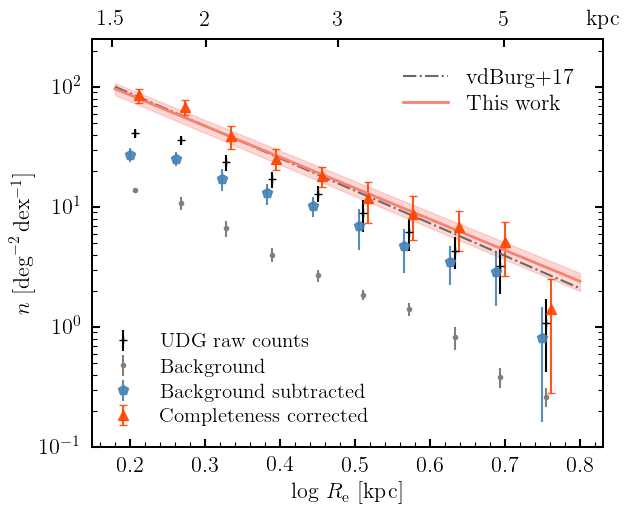

In [848]:
fig, ax = plt.subplots(figsize=(6.6, 5.4))

#  $n\propto R_e^{-2.78\pm0.25}$
# plt.axvline(np.log10(1.5), ls='-.', color='gray', zorder=0)

sct1 = plt.errorbar(cen, n_cen, yerr=n_std, 
             capsize=0,
             fmt='+', color='k', label='UDG raw counts')

sct2 = plt.errorbar(cen, n_cen_bkg, capsize=0,
             yerr=n_std_bkg, fmt='.', color='gray',
             markersize=6, label='Background')

sct3 = plt.errorbar(cen - 0.006, n_cen - n_cen_bkg, capsize=0,
             yerr=n_std, fmt='p', color='steelblue', alpha=0.9,
             markersize=7, label='Background subtracted')

sct4 = plt.errorbar(cen + 0.006, (n_cen - n_cen_bkg) / comp_avg, 
             yerr=np.sqrt(n_std**2 + n_std_bkg**2) / comp_avg, 
             fmt='^', color='orangered', alpha=0.9,
             markersize=7, label='Completeness corrected')

leg = plt.legend(loc=(0., 0.025), fontsize=15)
ax.add_artist(leg)

x0 = np.linspace(0.18, 0.8)
line1 = plt.plot(x0, 10**(-2.71 * x0 + 2.49), ls='-.', color='dimgray', label='vdBurg+17')
line2 = plt.plot(x0, pred_mean, color='salmon', lw=2, label='This work')
plt.fill_between(x0, pred_hpdi[0], pred_hpdi[1], alpha=0.3, color='salmon', interpolate=True)


plt.xlabel(r'$\log\,R_{\rm e}\ [\rm kpc]$')
plt.ylabel(r'$n\ [\deg^{-2} \rm dex^{-1}]$')

plt.legend(handles=[line1[0], line2[0]])

# Top banner
ax2 = ax.twiny() 
ax2.tick_params(direction='in')
lin_label = [1.5, 2, 3, 5, 7, 9]
lin_pos = [np.log10(i) for i in lin_label]
ax2.set_xticks(lin_pos)
ax2.set_xlim(ax.get_xlim())
ax2.set_xlabel(r'kpc', fontsize=16)
ax2.xaxis.set_label_coords(1, 1.035)
ax2.tick_params(which='minor', top=False)

ax2.set_xticklabels([r'$\mathrm{'+str(i)+'}$' for i in lin_label], fontsize=16)
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(16)

plt.yscale('log')

plt.ylim(0.1, 250)

plt.savefig('/tigress/jiaxuanl/public_html/figure/udg_paper/size_distribution.pdf', 
            bbox_inches='tight', dpi=50)

---

## Spatial distribution

In [1117]:
udg_cat = Table.read('/tigress/jiaxuanl/public_html/galary/catalogs/nsa_z001_004/udg_z001_004_spergel_after_viz.fits')

In [1118]:
udg_coord = SkyCoord(udg_cat['ra'], udg_cat['dec'], unit='deg')
host_coord = SkyCoord(udg_cat['host_RA'], udg_cat['host_DEC'], unit='deg')
dist = udg_coord.separation(host_coord)
dist_ratio = dist.to(u.deg).value / udg_cat['host_r_vir_ang'].data

In [1251]:
n_bins = 12
n_slide = 20
range_0 = np.array([0.25, 1.])

In [1252]:
# R_e distribution of the real udg sample
output, cen = moving_binned_statistic(dist_ratio, 
                                      dist_ratio, 
                                      x_err=None,
                                      bins=n_bins, range_=range_0, 
                                      statistic='count', n_slide=n_slide)
n_cen = np.nanmean(output, axis=0) / np.diff(cen)[0] / 278 # / (1) / total_area
n_std = np.nanstd(output, axis=0) / np.diff(cen)[0] / 278 # / (1) / total_area

In [1253]:
# completeness in each size bin
output, cen = moving_binned_statistic(dist_ratio, 
                                      udg_cat['completeness'], 
                                      x_err=None,
                                      bins=n_bins, range_=range_0, 
                                      statistic=np.nanmean, 
                                      n_slide=n_slide)
comp_avg = np.nanmean(output, axis=0)
comp_std = np.nanstd(output, axis=0)

In [1257]:
# R_e distribution of the fake udg sample: remove background
fake_udg_cat = Table.read('./Catalog/random_field/fake_udg_cat_220519.fits')

density_bkg = len(fake_udg_cat) / (5 * 20) / 24 # bkg per sqr deg

bins = np.histogram_bin_edges(dist_ratio, bins=n_bins, range=range_0)
unique_name, ind = np.unique(udg_cat['host_name'].data, return_index=True)

contam_profile = density_bkg * np.diff(
    np.pi * (bins * udg_cat['host_r_vir_ang'][:, None])**2) / np.diff(bins)[0]

n_cen_bkg = np.mean(contam_profile, axis=0)
n_std_bkg = np.std(contam_profile, axis=0)

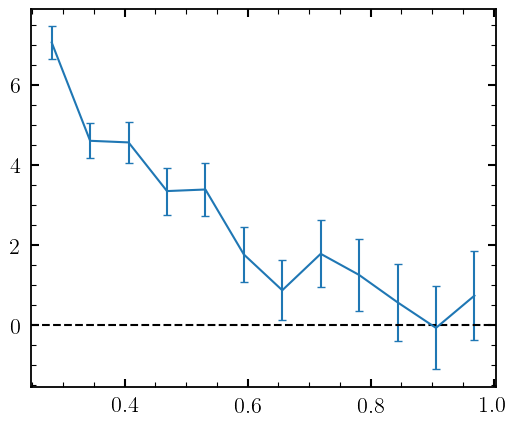

In [1258]:
plt.errorbar(cen, (n_cen - n_cen_bkg) / comp_avg, np.sqrt(n_std**2 + n_std_bkg**2))

plt.axhline(0, ls='--', c='k')

In [1259]:
n_corr = (n_cen - n_cen_bkg) / comp_avg

In [1260]:
from colossus.cosmology import cosmology
from colossus.halo import profile_nfw

cosmology.setCosmology('planck15')
p_nfw = profile_nfw.NFWProfile(M=1e11, c=10.0, z=0.0, mdef='vir')
res = p_nfw.fit(cen, n_corr, quantity='Sigma', method='leastsq')

-------------------------------------------------------------------------------------
Profile fit: Varying 2 / 2 parameters.
Could not find analytical derivative function for quantity Sigma.
Found solution in 76 steps. Best-fit parameters:
Parameter       rhos = 5.09e+02 [6.27e+01 .. 4.14e+03]
Parameter         rs = 9.57e-02 [4.36e-02 .. 2.10e-01]
chi2 / Ndof = 3.8 / 10 = 0.38
-------------------------------------------------------------------------------------


In [1261]:
1 / res['x'][1]

10.448048879927194

In [1262]:
p_nfw = profile_nfw.NFWProfile(rs=res['x'][1], rhos=res['x'][0], mdef = 'vir')
rs = np.linspace(0.1, 1, 100)# * 300
sigmas = p_nfw.surfaceDensity(rs)

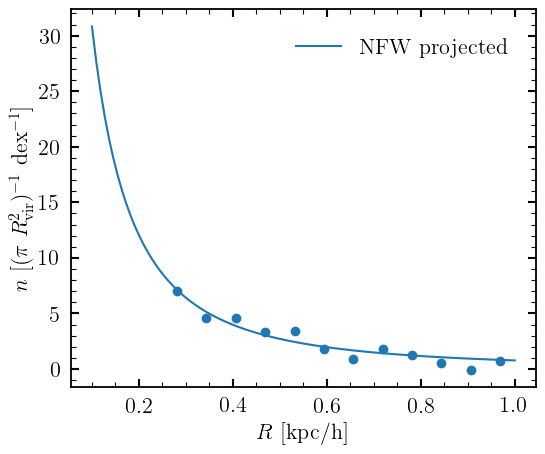

In [1263]:
plt.scatter(cen, n_corr)
plt.plot(rs, sigmas, label='NFW projected')

plt.xlabel(r'$R\ [\rm kpc/h]$')
plt.ylabel(r'$n\ [(\pi\ R_{\rm vir}^2)^{-1}\ \rm dex^{-1}]$')

plt.legend()

---

In [1475]:
unique_name, ind = np.unique(udg_cat['host_name'].data, return_index=True)

In [1504]:
n_bins = 10
n_slide = 20
range_0 = np.array([0.3, 1.])

In [1551]:
n_cens = []
n_stds = []
for name in unique_name[:]:
    output, cen = moving_binned_statistic(dist_ratio[udg_cat['host_name'] == name], 
                                          dist_ratio[udg_cat['host_name'] == name], 
                                          x_err=None,
                                          bins=n_bins, range_=range_0, 
                                          statistic='count', n_slide=n_slide)
    n_cen = np.nanmean(output, axis=0) / np.diff(cen)[0] # / (1) / total_area
    n_std = np.nanstd(output, axis=0) / np.diff(cen)[0] # / (1) / total_area
    n_cens.append(n_cen)
    n_stds.append(n_std)

In [1552]:
n_cen = np.sum(np.array(n_cens), axis=0)
n_std = np.sqrt(np.sum(np.array(n_stds)**2, axis=0))
# n_stds = np.std(np.array(n_cens), axis=0) / np.sqrt(len(ind))

In [1553]:
# completeness in each size bin
output, cen = moving_binned_statistic(dist_ratio, 
                                      udg_cat['completeness'], 
                                      x_err=None,
                                      bins=n_bins, range_=range_0, 
                                      statistic=np.nanmean, 
                                      n_slide=n_slide)
comp_avg = np.nanmean(output, axis=0)
comp_std = np.nanstd(output, axis=0)

In [1554]:
# R_e distribution of the fake udg sample: remove background
fake_udg_cat = Table.read('./Catalog/random_field/fake_udg_cat_220519.fits')

density_bkg = len(fake_udg_cat) / (5 * 20) / 24 # bkg per sqr deg

bins = np.histogram_bin_edges(dist_ratio, bins=n_bins, range=range_0)
unique_name, ind = np.unique(udg_cat['host_name'].data, return_index=True)

contam_profile = density_bkg * np.diff(
    np.pi * (bins * udg_cat[ind]['host_r_vir_ang'][:, None])**2) / np.diff(bins)[0]

n_cen_bkg = np.sum(contam_profile, axis=0)
# n_std_bkg = np.std(contam_profile, axis=0)

In [1556]:
_n_cen_bkg = []

for i in range(10):
    _ind = np.random.choice(np.arange(len(udg_cat)), len(ind))
    _contam_profile = density_bkg * np.diff(
        np.pi * (bins * udg_cat[_ind]['host_r_vir_ang'][:, None])**2) / np.diff(bins)[0]
    _n_cen_bkg.append(np.sum(_contam_profile, axis=0))

In [1557]:
n_std_bkg = np.std(np.array(_n_cen_bkg), axis=0)

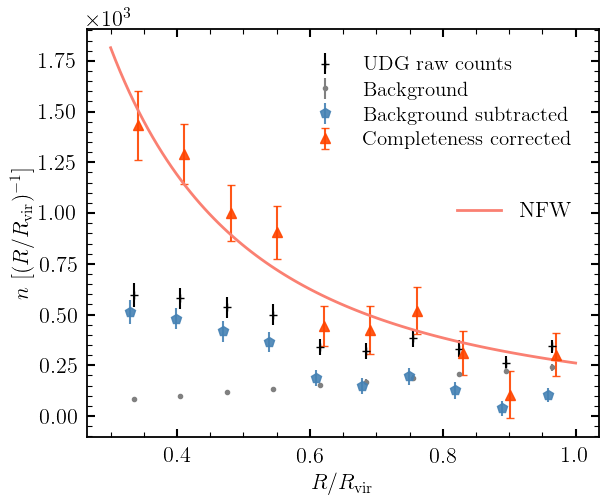

In [1559]:
fig, ax = plt.subplots(figsize=(6.6, 5.4))

#  $n\propto R_e^{-2.78\pm0.25}$
# plt.axvline(np.log10(1.5), ls='-.', color='gray', zorder=0)

sct1 = plt.errorbar(cen, n_cen, yerr=n_std, 
             capsize=0,
             fmt='+', color='k', label='UDG raw counts')

sct2 = plt.errorbar(cen, n_cen_bkg, capsize=0,
             yerr=n_std_bkg, fmt='.', color='gray',
             markersize=6, label='Background')

sct3 = plt.errorbar(cen - 0.006, n_cen - n_cen_bkg, capsize=0,
             yerr=n_std, fmt='p', color='steelblue', alpha=0.9,
             markersize=7, label='Background subtracted')

n_corr = (n_cen - n_cen_bkg) / comp_avg
n_corr_std = n_corr * np.sqrt(
    (np.sqrt(n_std**2 + n_std_bkg**2) / (n_cen - n_cen_bkg))**2 + (comp_std / comp_avg)**2
)

sct4 = plt.errorbar(cen + 0.006, n_corr, 
             yerr=n_corr_std, 
             fmt='^', color='orangered', alpha=0.9,
             markersize=7, label='Completeness corrected')

leg = plt.legend(loc='upper right', fontsize=15)
ax.add_artist(leg)


line1 = plt.plot(rs, sigmas, ls='-', color='salmon', lw=2, label='NFW')
# line1 = plt.plot(x0, 10**(-2.71 * x0 + 2.49), ls='-.', color='dimgray', label='vdBurg+17')
# line2 = plt.plot(x0, pred_mean, color='salmon', lw=2, label='This work')
# plt.fill_between(x0, pred_hpdi[0], pred_hpdi[1], alpha=0.3, color='salmon', interpolate=True)


plt.xlabel(r'$R/R_{\rm vir}$')
plt.ylabel(r'$n\ [(R/R_{\rm vir})^{-1}]$')

plt.legend(handles=[line1[0]], loc=(0.7, 0.5))

# plt.yscale('log')

# plt.ylim(0.1, 250)

# plt.ylim(-0.2,)
# plt.legend()

In [1538]:
from colossus.cosmology import cosmology
from colossus.halo import profile_nfw

cosmology.setCosmology('planck15')
p_nfw = profile_nfw.NFWProfile(M=1e11, c=10.0, z=0.0, mdef='vir')
res = p_nfw.fit(cen, n_corr, quantity='Sigma', method='leastsq')

-------------------------------------------------------------------------------------
Profile fit: Varying 2 / 2 parameters.
Could not find analytical derivative function for quantity Sigma.
Found solution in 108 steps. Best-fit parameters:
Parameter       rhos = 1.64e+29 [0.00e+00 ..     inf]
Parameter         rs = 6.10e-10 [0.00e+00 ..     inf]
chi2 / Ndof = 22966.5 / 8 = 2870.81
-------------------------------------------------------------------------------------


In [1539]:
1 / res['x'][1]

1639618755.4905334

In [1456]:
p_nfw = profile_nfw.NFWProfile(rs=res['x'][1], rhos=res['x'][0], mdef = 'vir')
rs = np.linspace(0.3, 1, 100)
sigmas = p_nfw.surfaceDensity(rs)

---

In [1525]:
contam_profile = density_bkg * np.diff(
    np.pi * (bins * udg_cat[ind]['host_r_vir_ang'][:, None])**2) / (np.diff(np.pi * bins**2))

In [1528]:
n_cen_bkg = np.sum(contam_profile, axis=0)

In [1555]:
n_cen_bkg

array([ 83.14285399, 100.51598765, 117.88912132, 135.26225499,
       152.63538866, 170.00852233, 187.381656  , 204.75478967,
       222.12792333, 239.501057  ])